In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

c:\users\yanni\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
books_data_raw = pd.read_csv('data/Books_rating.csv')
books_data_raw

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,NaN,14/19,4.0,937612800,Difficult,"This is an extremely difficult book to digest,..."
2999996,B000NSLVCU,The Idea of History,NaN,A1SMUB9ASL5L9Y,jafrank,1/1,4.0,1331683200,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...
2999997,B000NSLVCU,The Idea of History,NaN,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",0/0,4.0,1180224000,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i..."
2999998,B000NSLVCU,The Idea of History,NaN,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",1/11,5.0,1163030400,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,..."


In [5]:
books_data = books_data_raw[['review/score', 'review/text']].copy()
books_data.rename(columns={'review/score': 'score', 'review/text': 'text'}, inplace=True)

# TODO: use more 10000
# books_data = books_data.head(10000)

In [6]:
books_data = books_data.dropna()
len(books_data)

2999992

<AxesSubplot: xlabel='score', ylabel='count'>

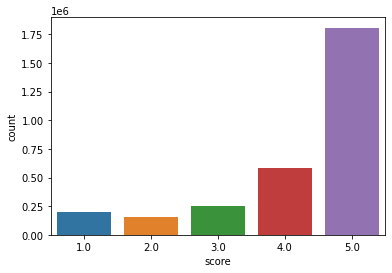

In [8]:


sns.countplot(x='score', data=books_data)

In [5]:
X = books_data.text
y = books_data.score
X.head()

0    This is only for Julie Strain fans. It's a col...
1    I don't care much for Dr. Seuss but after read...
2    If people become the books they read and if "t...
3    Theodore Seuss Geisel (1904-1991), aka &quot;D...
4    Philip Nel - Dr. Seuss: American IconThis is b...
Name: text, dtype: object

In [6]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [7]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
X = pad_sequences(X, padding='post')

In [8]:
# One-hot encoding
y = np_utils.to_categorical([int(score) - 1 for score in y])
y[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
embeddings_dict = dict()
embeddings_file = open('data/glove.6B.300d.txt', encoding="utf8")
for line in embeddings_file:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = vector
embeddings_file.close()

In [12]:
embeddings_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding = embeddings_dict.get(word)
    if embedding is not None:
        embeddings_matrix[index] = embedding

In [13]:
model = Sequential()

embedding_layer = Embedding(
    vocab_size,
    300,
    weights=[embeddings_matrix],
    input_length=max([len(sent) for sent in X]),
    trainable=False
)
model.add(embedding_layer)

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2166, 300)         13560600  
                                                                 
 flatten (Flatten)           (None, 649800)            0         
                                                                 
 dense (Dense)               (None, 32)                20793632  
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 34,355,453
Trainable params: 20,794,853
Non-trainable params: 13,560,600
_________________________________________________________________
None


In [14]:
BATCH_SIZE = 1024
EPOCHS = 10

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/10
7/7 [==============================] - 37s 4s/step - loss: 1.6874 - accuracy: 0.4530 - val_loss: 1.4798 - val_accuracy: 0.5175
Epoch 2/10
7/7 [==============================] - 21s 3s/step - loss: 1.2109 - accuracy: 0.5742 - val_loss: 1.3281 - val_accuracy: 0.5756
Epoch 3/10
7/7 [==============================] - 24s 3s/step - loss: 1.0101 - accuracy: 0.6453 - val_loss: 1.2782 - val_accuracy: 0.5650
Epoch 4/10
7/7 [==============================] - 18s 2s/step - loss: 0.8392 - accuracy: 0.6955 - val_loss: 1.2620 - val_accuracy: 0.5594
Epoch 5/10
7/7 [==============================] - 17s 2s/step - loss: 0.7123 - accuracy: 0.7416 - val_loss: 1.2802 - val_accuracy: 0.5525
Epoch 6/10
7/7 [==============================] - 18s 3s/step - loss: 0.5958 - accuracy: 0.8009 - val_loss: 1.2772 - val_accuracy: 0.5587
Epoch 7/10
7/7 [==============================] - 16s 2s/step - loss: 0.4961 - accuracy: 0.8352 - val_loss: 1.3202 - val_accuracy: 0.5556
Epoch 8/10
7/7 [==================

In [15]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

63/63 [==============================] - 4s 58ms/step - loss: 1.3574 - accuracy: 0.5585
Test Score: 1.357380986213684
Test Accuracy: 0.5584999918937683
